# Li building PP from GBRV rho with PBE with TF02vW

In [1]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import environ

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# from scipy.signal import quadratic

In [3]:
from ase.build import molecule
from ase.atoms import Atoms
from ase.io import read

In [4]:
atoms = read('../../../KS/PBE/rho_ks_Li_gbrv.xsf')

In [5]:
ions, rho_ks, _ = io.read_all('../../../KS/PBE/rho_ks_Li_gbrv.xsf')
grid = rho_ks.grid


In [6]:
PP_list = {'Li': '/projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/Li/li_pbe_v1.4.uspp.F.UPF',}

In [46]:
# MaxPoints=1000
# PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)#, MaxPoints=MaxPoints)
rho_ini =rho_ks.copy()
PSEUDO = Functional(type='PSEUDO', grid=rho_ks.grid, ions=ions, PP_list=PP_list)
core = PSEUDO.core_density ## GBRV don't have NLCC

setting key: Li -> /projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/Li/li_pbe_v1.4.uspp.F.UPF


In [8]:
KE = Functional(type='KEDF',name='TFvW', y=0.2)
XC = Functional(type='XC',name='PBE', core_density=core)
HARTREE = Functional(type='HARTREE')

In [9]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

In [10]:
optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
rho = opt.optimize_rho(guess_rho=rho_ks)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -9.634074175730E-01     -9.634074E-01   2.210932E+01    1       1       3.179245E-01    
1       -3.120252668104E+00     -2.156845E+00   3.544692E+00    1       2       6.355605E-01    
2       -3.219523055905E+00     -9.927039E-02   1.032145E+01    1       2       9.486825E-01    
3       -3.377567523258E+00     -1.580445E-01   9.915332E+00    1       2       1.241277E+00    
4       -3.466776584534E+00     -8.920906E-02   4.194953E+00    1       2       1.553203E+00    
5       -3.516022144971E+00     -4.924556E-02   1.931856E+00    1       2       1.799968E+00    
6       -3.539278078108E+00     -2.325593E-02   1.201251E+00    1       2       2.039149E+00    
7       -3.558794804433E+00     -1.951673E-02   1.369312E+00    1       3       2.369442E+00    
8       -3.575943833420E+00     -1.714903E-02   1.282891E+00    1       3       2.700229E+00    
9       -3.592085066875E+00   

In [11]:
delta = 0.5 * np.abs(rho_ks - rho).integral()

In [12]:
delta

1.0814421522936875

In [13]:
kfmax=( np.max(rho) * 3 * np.pi )**(1.0/3.0)+0.2

In [14]:
from dftpy.mixer.pulay import PulayMixer

In [15]:
from dftpy.optimization import OESCF

In [16]:
pulay=PulayMixer(mp=None)

In [17]:
opt_options = {'econv' : 1e-6}

In [18]:
vW = Functional(type='KEDF', name='vW')
evaluator = TotalFunctional(KE=vW, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

kedf_emb = Functional(type='KEDF',name='LMGP')#, kfmax=kfmax, kfmin=1e-10, ratio=1.02)
kedf_emb.options.update({'y':0})
evaluator_emb = TotalFunctional(KEDF_EMB = kedf_emb)

opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options, optimization_method = 'CG')
opt = OESCF(optimization=opt, evaluator_emb=evaluator_emb, guess_rho=rho,mixer=pulay)

In [19]:
rho_lmgp = opt.optimize_rho(guess_rho=rho_ks, econv=1e-6)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.450338112752E-01      8.450338E-01    1.900691E+01    1       1       6.808162E-02    
1       -1.466031371963E+00     -2.311065E+00   9.843922E+00    1       3       5.063024E-01    
2       -1.768442350104E+00     -3.024110E-01   3.706240E+01    1       3       9.445395E-01    
3       -1.841806274309E+00     -7.336392E-02   2.381686E+01    1       2       1.237974E+00    
4       -1.923100647096E+00     -8.129437E-02   4.032947E+01    1       2       1.531337E+00    
5       -2.032626420741E+00     -1.095258E-01   4.056952E+01    1       2       1.829654E+00    
6       -2.112645530213E+00     -8.001911E-02   2.361704E+01    1       2       2.124504E+00    
7       -2.164339372640E+00     -5.169384E-02   1.673020E+01    1       2       2.421684E+00    
8       -2.210757825946E+00     -4.641845E-02   1.340420E+01    1       2       2.715332E+00    
9       -2.256073409093E+00   

In [20]:
delta = 0.5 * np.abs(rho_ks - rho_lmgp).integral()
print(delta)

1.098250646253076


Text(0.5, 1.0, 'OF LMGP')

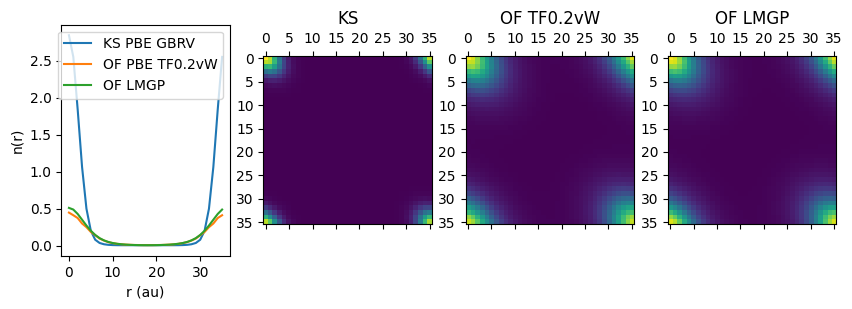

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
r = np.linspace(0,ions.cell[2][2],len(rho_ks[0,0,:].ravel()))
cut = 0
axs[0].plot(rho_ks[:,cut,cut].ravel(), label='KS PBE GBRV')
axs[0].plot(rho[:,cut,cut].ravel(), label='OF PBE TF0.2vW')
axs[0].plot((rho_lmgp[:,cut,cut]).ravel(), label='OF LMGP')
axs[0].legend()
axs[0].set_ylabel('n(r)')
axs[0].set_xlabel('r (au)')

axs[1].matshow(rho_ks[cut,:,:])
axs[1].set_title('KS')
axs[2].matshow(rho[cut,:,:])
axs[2].set_title('OF TF0.2vW')
axs[3].matshow(rho_lmgp[cut,:,:])
axs[3].set_title('OF LMGP')

In [22]:
rho.write('rho_TF02vW_Li.xsf', ions=ions)
rho_lmgp.write('rho_LMGP_Li.xsf', ions=ions)

In [23]:
rho_ks.integral(), rho.integral(), rho_lmgp.integral()

(2.9999999999746856, 2.9999999999746993, 2.999999999974701)

### PP optimitization

In [24]:
def delta_pp(r, rcut, a):
    d = r - rcut
    b = (3*a[0]*rcut-4*a[1]*rcut**2+5*a[2]*rcut**3)/2.0
    v = b*d**2 + a[0]*d**3 + a[1]*d**4+a[2]*d**5
    v[r>rcut] = 0.0
    return v

def lpp2vloc(r, v, ions, grid, key, zval=0.0):
    engine = PSP(None)
    engine.r = r
    engine.v = v
    engine._zval = zval
    pseudo = LocalPseudo(grid = grid, ions=ions, PP_list={key:engine})#, MaxPoints=MaxPoints)
    pseudo.local_PP()
    return pseudo._vreal

In [25]:
key='Li'
grid = rho_ks.grid
rcut = 2.0 # Taken from the GBRV PP cutoff radius
r = np.linspace(0, rcut, 100)
a = np.zeros(3)
# KE = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
KE = Functional(type='KEDF',name='TFvW', y=0.2)
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
ext = Functional(type='EXT')
evaluator.UpdateFunctional(newFuncDict={'EXT': ext})

optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator,optimization_options = optimization_options, optimization_method = 'CG')


rho_ini = rho_ks.copy()
environ['LOGLEVEL'] = 4
def delta_rho(a):
    print('Init')
    v = delta_pp(r, rcut, a)
    ext.v = lpp2vloc(r, v, ions, grid, key)
    rho = opt.optimize_rho(guess_rho=rho_ini)
    # rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_ks)).integral()
    # if i%50==0 and i>1:
    print('aa:', a, diff)
    return diff

In [26]:
res = minimize(delta_rho, a, method='Powell', options={'ftol': 1.0e-4})


Init
aa: [0. 0. 0.] 1.0814421522936875
Init
aa: [0. 0. 0.] 1.0814421522936875
Init
aa: [1. 0. 0.] 1.8713461494356307
Init
aa: [-1.618034  0.        0.      ] 1.2137685886998375
Init
aa: [0. 0. 0.] 1.0814421522936875
Init
aa: [-0.61803397  0.          0.        ] 1.3047209288320558
Init
aa: [0.381966 0.       0.      ] 1.3377858428007512
Init
aa: [-0.13404777  0.          0.        ] 1.1020516464842192
Init
aa: [0.11225937 0.         0.        ] 1.1098614549686427
Init
aa: [-0.0204908  0.         0.       ] 1.0826223051452866
Init
aa: [0.02376406 0.         0.        ] 1.0851207326265746
Init
aa: [-0.00424506  0.          0.        ] 1.082911557028283
Init
aa: [0.00907706 0.         0.        ] 1.083771892938384
Init
aa: [0.00346713 0.         0.        ] 1.0833885037262687
Init
aa: [-0.00162147  0.          0.        ] 1.081375936640856
Init
aa: [-0.00262359  0.          0.        ] 1.0813388913121682
Init
aa: [-0.00324294  0.          0.        ] 1.0813433882779333
Init
aa: [-0.002800

In [30]:
environ['LOGLEVEL'] = 2

In [47]:
# a = res.x
key = 'Li'
r = PSEUDO.readpp.pp[key].r
zval = PSEUDO.readpp.pp[key]._zval
vl = PSEUDO.readpp.pp[key].v
v = delta_pp(r, rcut, a)
v += vl

engine = PSP(None)
engine.r = r
engine.v = v
engine.info['atomicnum'] = 3
engine._zval = zval

In [55]:
engine.write('PGBRV_PBE_TF02vW.psp8')
np.save('a_pbe_tf02vw',a)

Text(0.5, 1.0, 'Li LPP from GBRV rho with PBE with TF02vW')

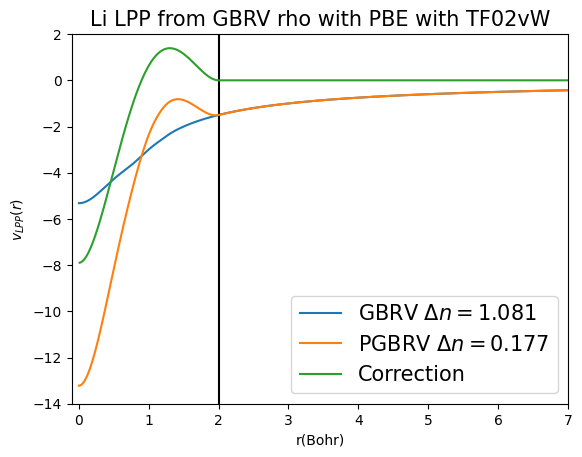

In [54]:
import matplotlib.pyplot as plt
plt.plot(r,vl, label='GBRV $\Delta n = 1.081$')
rcut = 2.0
r1=np.linspace(start=0.01,stop=10,num=1000)
# plt.plot(r,-3/(r+0.1))
#plt.scatter(np.arange(10),np.zeros(10)-4)
plt.vlines(x=rcut,ymin=-14,ymax=3,colors='k')
plt.plot(r,v, label='PGBRV $\Delta n = 0.177$')
plt.plot(r1,delta_pp(r1,rcut,a), label='Correction')
plt.ylim(-14,2)
plt.xlim(-0.1,7)
plt.xlabel('r(Bohr)')
plt.ylabel('$v_{LPP}(r)$')
plt.legend(fontsize=15)
plt.title('Li LPP from GBRV rho with PBE with TF02vW', fontsize=15)

In [ ]:
plt.plot(rho[0,0,:].ravel())
plt.plot(rho_ks[0,0,:].ravel())